## 不使用数据增强的快速特征提取
使用在 ImageNet 上训练的 VGG16 网络的卷积基从猫狗图像中提取有趣的特征，然后在这些特征上训练

In [1]:
# 将 VGG16 卷积基实例化
# https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5
from keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
# 使用预训练的卷积基提取特征
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './data/cats_and_dogs_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
    directory,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [3]:
# 定义并训练密集连接分类器
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.6059 - acc: 0.6695 - val_loss: 0.4327 - val_acc: 0.8280
Epoch 2/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.4282 - acc: 0.8105 - val_loss: 0.3576 - val_acc: 0.8640
Epoch 3/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3538 - acc: 0.8520 - val_loss: 0.3160 - val_acc: 0.8750
Epoch 4/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.3122 - acc: 0.8775 - val_loss: 0.2997 - val_acc: 0.8790
Epoch 5/30
2000/2000 [==============================] - 6s 3ms/step - loss: 0.2737 - acc: 0.8895 - val_loss: 0.2842 - val_acc: 0.8810
Epoch 6/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.2738 - acc: 0.8915 - val_loss: 0.2710 - v

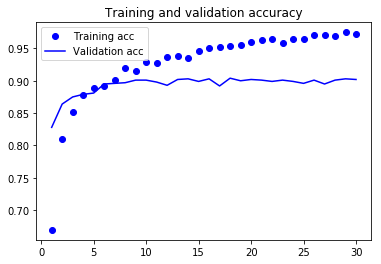

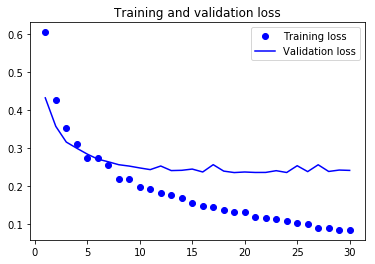

In [4]:
# 绘制训练过程中的损失曲线和精度曲线
import matplotlib.pyplot as plt 
%matplotlib inline

acc = history.history['acc'] 
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss'] 

epochs = range(1, len(acc) + 1) 

plt.plot(epochs, acc, 'bo', label='Training acc') 
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy') 
plt.legend() 

plt.figure() 

plt.plot(epochs, loss, 'bo', label='Training loss') 
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss') 
plt.legend() 

plt.show()